In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import missingno as msno

from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from impyute.imputation.cs import mice

In [2]:
df = pd.read_csv('D:/DM_Project_Dataset/training.csv')
pd.set_option('display.max_columns', None)
df.head()

RefId  IsBadBuy   PurchDate  Auction  VehYear  VehicleAge      Make  \
0    326         1  10/25/2010    ADESA     2008           2       KIA   
1  42991         0   5/27/2009  MANHEIM     2006           3     DODGE   
2  55273         0   3/18/2010    OTHER     2008           2     DODGE   
3  29058         0    6/8/2009    OTHER     2005           4      FORD   
4  34991         0    3/4/2009  MANHEIM     2005           4  CHRYSLER   

                  Model Trim          SubModel   Color Transmission  \
0               SPECTRA   EX       4D SEDAN EX    BLUE         AUTO   
1  STRATUS V6 2.7L V6 M  SXT  4D SEDAN SXT FFV  SILVER         AUTO   
2               CALIBER   SE          4D WAGON   BLACK         AUTO   
3  FREESTAR FWD V6 3.9L    S    PASSENGER 3.9L   BROWN         AUTO   
4  TOWN & COUNTRY FWD V  Bas      MINIVAN 3.3L    BLUE         AUTO   

   WheelTypeID WheelType  VehOdo  Nationality    Size TopThreeAmericanName  \
0          2.0    Covers   61184  OTHER ASIAN  MEDIUM                OTHER   
1          2.0    Covers   92383     AMERICAN  MEDIUM             CHRYSLER   
2          2.0    Covers   45965     AMERICAN  MEDIUM             CHRYSLER   
3          2.0    Covers   80169     AMERICAN     VAN                 FORD   
4          1.0     Alloy   77372     AMERICAN     VAN             CHRYSLER   

   MMRAcquisitionAuctionAveragePrice  MMRAcquisitionAuctionCleanPrice  \
0                             6796.0                           7555.0   
1                             5480.0                           6461.0   
2                             8067.0                           8580.0   
3                             4817.0                           6658.0   
4                             5430.0                           6633.0   

   MMRAcquisitionRetailAveragePrice  MMRAcquisitonRetailCleanPrice  \
0                           10140.0                        10805.0   
1                            6418.0                         7478.0   
2                           11073.0                        11652.0   
3                            5702.0                         7691.0   
4                            6364.0                         7664.0   

   MMRCurrentAuctionAveragePrice  MMRCurrentAuctionCleanPrice  \
0                         6628.0                       7535.0   
1                         5480.0                       6461.0   
2                         7497.0                       8102.0   
3                         4817.0                       6658.0   
4                         5370.0                       6811.0   

   MMRCurrentRetailAveragePrice  MMRCurrentRetailCleanPrice PRIMEUNIT  \
0                        9605.0                     10650.0       NaN   
1                        6418.0                      7478.0       NaN   
2                       10721.0                     11350.0       NaN   
3                        5702.0                      7691.0       NaN   
4                        6300.0                      7856.0       NaN   

  AUCGUART  BYRNO  VNZIP1 VNST  VehBCost  IsOnlineSale  WarrantyCost  
0      NaN   5546   33619   FL    6100.0             0           533  
1      NaN  99750   32124   FL    4000.0             0          1630  
2      NaN  99761   74135   OK    7500.0             0           693  
3      NaN  99761   85018   AZ    4725.0             0          1633  
4      NaN  20833   75236   TX    5670.0             0          1623

# Data Preprocessing

In [3]:
# considering that of the attributes that are int64 or float64, 
# the only ones whose average makes sense are all the MMRs, VehBCost, WarrantyCost, 
# and possibly also vehOdo, vehYear and vehAge. 
# The others are all counters (refId and BYRNO) or categories (all others)

df.describe()

RefId      IsBadBuy       VehYear    VehicleAge   WheelTypeID  \
count  58386.000000  58386.000000  58386.000000  58386.000000  55813.000000   
mean   36567.888449      0.123454   2005.344637      4.174956      1.495566   
std    21092.254801      0.328961      1.733307      1.713833      0.520802   
min        1.000000      0.000000   2001.000000      0.000000      0.000000   
25%    18270.250000      0.000000   2004.000000      3.000000      1.000000   
50%    36608.500000      0.000000   2005.000000      4.000000      1.000000   
75%    54811.500000      0.000000   2007.000000      5.000000      2.000000   
max    73014.000000      1.000000   2010.000000      9.000000      3.000000   

              VehOdo  MMRAcquisitionAuctionAveragePrice  \
count   58386.000000                       58373.000000   
mean    71478.090518                        6128.127953   
std     14591.224550                        2456.632611   
min      4825.000000                           0.000000   
25%     61785.000000                        4273.000000   
50%     73359.000000                        6097.000000   
75%     82427.000000                        7765.000000   
max    115717.000000                       35722.000000   

       MMRAcquisitionAuctionCleanPrice  MMRAcquisitionRetailAveragePrice  \
count                     58373.000000                      58373.000000   
mean                       7372.912699                       8497.288558   
std                        2715.506462                       3151.106237   
min                           0.000000                          0.000000   
25%                        5409.000000                       6279.000000   
50%                        7308.000000                       8448.000000   
75%                        9017.000000                      10652.000000   
max                       36859.000000                      39080.000000   

       MMRAcquisitonRetailCleanPrice  MMRCurrentAuctionAveragePrice  \
count                   58373.000000                   58141.000000   
mean                     9851.768061                    6131.666655   
std                      3378.839613                    2432.171539   
min                         0.000000                       0.000000   
25%                      7501.000000                    4275.000000   
50%                      9798.000000                    6063.000000   
75%                     12084.000000                    7737.000000   
max                     41482.000000                   35722.000000   

       MMRCurrentAuctionCleanPrice  MMRCurrentRetailAveragePrice  \
count                 58141.000000                  58141.000000   
mean                   7389.958652                   8776.065118   
std                    2682.310828                   3086.373733   
min                       0.000000                      0.000000   
25%                    5415.000000                   6538.000000   
50%                    7311.000000                   8733.000000   
75%                    9014.000000                  10910.000000   
max                   36859.000000                  39080.000000   

       MMRCurrentRetailCleanPrice         BYRNO        VNZIP1      VehBCost  \
count                58141.000000  58386.000000  58386.000000  58386.000000   
mean                 10145.227034  26359.191519  58125.258195   6730.008335   
std                   3304.637060  25804.795573  26146.806098   1762.075265   
min                      0.000000    835.000000   2764.000000      1.000000   
25%                   7788.000000  17212.000000  32124.000000   5430.000000   
50%                  10103.000000  19662.000000  74135.000000   6700.000000   
75%                  12309.000000  22808.000000  80022.000000   7900.000000   
max                  41062.000000  99761.000000  99224.000000  36485.000000   

       IsOnlineSale  WarrantyCost  
count  58386.000000  58386.000000  
mean       0.025674   1276.105042  
std        0

In [4]:
df.rename(columns={ 'MMRAcquisitionAuctionAveragePrice':'AAAP',
                    'MMRAcquisitionRetailAveragePrice':'ARAP',
                    'MMRCurrentAuctionAveragePrice':'CAAP',
                    'MMRCurrentRetailAveragePrice':'CRAP',
                    'MMRAcquisitionAuctionCleanPrice': 'AACP',
                    'MMRAcquisitonRetailCleanPrice': 'ARCP',
                    'MMRCurrentAuctionCleanPrice': 'CACP',
                    'MMRCurrentRetailCleanPrice': 'CRCP'
                  },inplace=True)

# Missing Data Handling

In [5]:
sum_ = df.isnull().sum()
sum_[sum_ != 0]

Trim                     1911
SubModel                    7
Color                       7
Transmission                8
WheelTypeID              2573
WheelType                2577
Nationality                 4
Size                        4
TopThreeAmericanName        4
AAAP                       13
AACP                       13
ARAP                       13
ARCP                       13
CAAP                      245
CACP                      245
CRAP                      245
CRCP                      245
PRIMEUNIT               55703
AUCGUART                55703
dtype: int64

<AxesSubplot:>

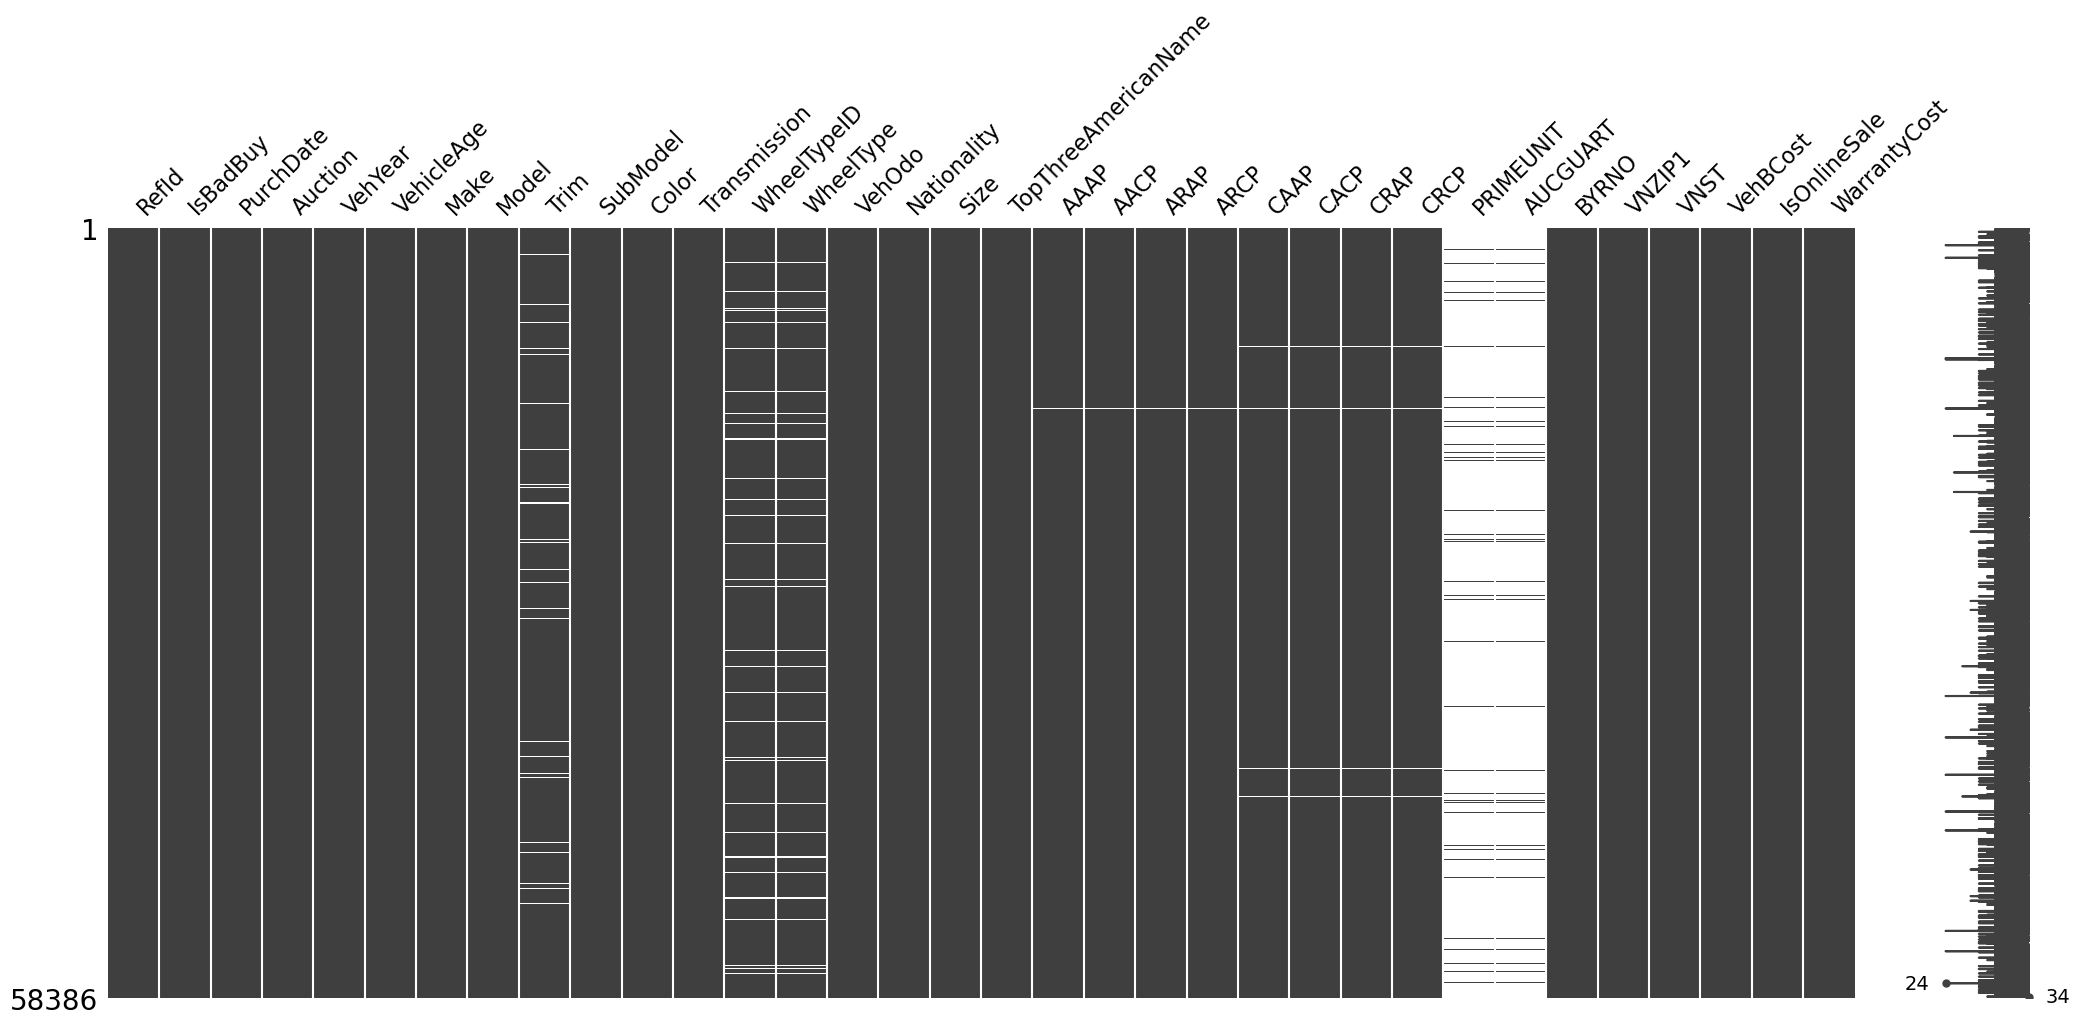

In [6]:
#Visualising Missing Values

msno.matrix(df)

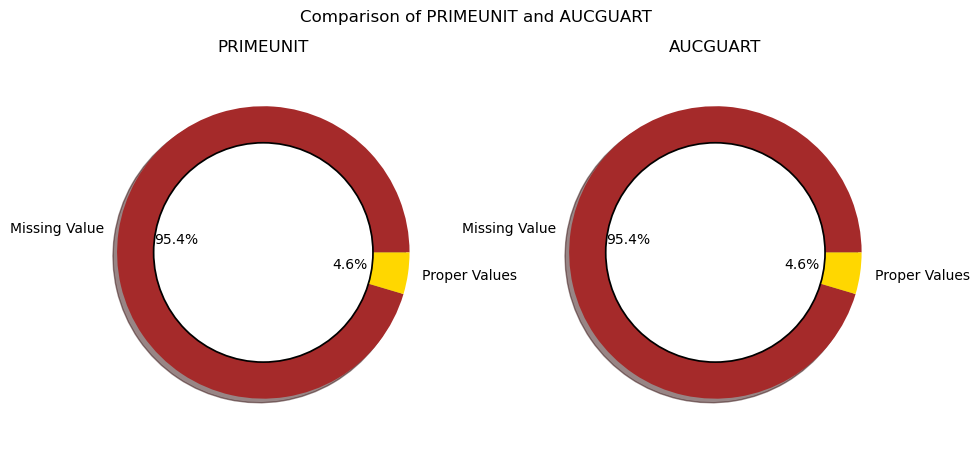

In [7]:
# Prepare data for PRIMEUNIT pie chart
NaN_primeunit = []
a_primeunit = []
for i in df['PRIMEUNIT']:
    if i != 'YES' and i != 'NO':
        NaN_primeunit.append(i)
    else:
        a_primeunit.append(i)
NaN_primeunit = len(NaN_primeunit)
TOT_primeunit = len(a_primeunit)

# Prepare data for AUCGUART pie chart
NaN_aucguart = []
a_aucguart = []
for i in df['AUCGUART']:
    if i == 'RED' or i=='GREEN' or i=='YELLOW':
        a_aucguart.append(i)
    else:
        NaN_aucguart.append(i)
NaN_aucguart = len(NaN_aucguart)
TOT_aucguart = len(a_aucguart)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Draw PRIMEUNIT pie chart in the first subplot
labels = 'Missing Value', 'Proper Values'
sizes = [NaN_primeunit, TOT_primeunit]
colors = ['brown', 'gold']
explode = (0, 0)
ax1.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)
ax1.set_title('PRIMEUNIT')

# Draw AUCGUART pie chart in the second subplot
labels = 'Missing Value', 'Proper Values'
sizes = [NaN_aucguart, TOT_aucguart]
colors = ['brown', 'gold']
explode = (0, 0)
ax2.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)
ax2.set_title('AUCGUART')

# Draw a circle at the center of each pie chart to make it look like a donut
centre_circle1 = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
ax1.add_artist(centre_circle1)
centre_circle2 = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
ax2.add_artist(centre_circle2)

# Set aspect ratio to be equal so that each pie chart is drawn as a circle
ax1.axis('equal')
ax2.axis('equal')

# Add a title to the entire figure
fig.suptitle('Comparison of PRIMEUNIT and AUCGUART')


# Show the combined plot
fig.subplots_adjust(wspace=0.4)
plt.show()


Since PRIMEUNIT nad AUCGUART have majority of missing values, we plan to remove these columns

In [8]:
df.drop(columns=['PRIMEUNIT', 'AUCGUART'],inplace=True)

In [9]:
#Since SIZE and SUBMODEL are quite the same, if SUBMODEL is NaN I substitute it with SIZE
df['Size'].fillna('NULL', inplace=True)
for size in df['Size'].unique():
    #Find the mode of size for the corresponding Submodel
    mode = df[df['Size']==size][['Size','SubModel']]['SubModel'].mode()[0]
    positions = (df['SubModel'].isna()) & (df['Size'] == size)
    df['SubModel'] = np.where(positions, mode, df['SubModel'])

In [10]:
df['CAAP'].fillna(df['AAAP'],inplace=True)
print(df['CAAP'].isnull().sum())

13


Similarly for other columns

In [11]:
df['CRAP'].fillna(df['ARAP'],inplace=True)
df['CACP'].fillna(df['AACP'],inplace=True)
df['CRCP'].fillna(df['ARCP'],inplace=True)

In [12]:
# Impute missing values with mode of colour
df['Color'].fillna(df['Color'].mode()[0], inplace=True)
df['Color'].isnull().sum()

0

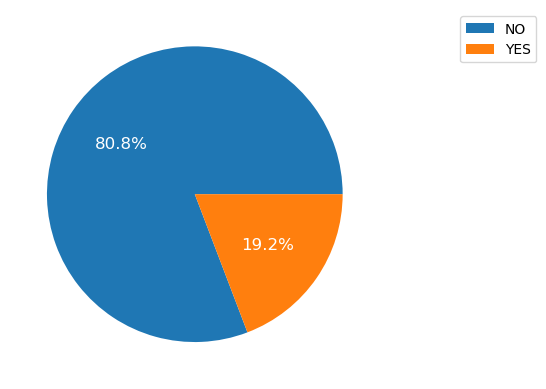

In [13]:
#Percentage of people buying base variant car
list1 = []

for i in df['Trim']:
    if i == 'Bas':
        list1.append('YES')
    else:
        list1.append("NO")

df['IsBase'] = list1
plot = df['IsBase'].value_counts().plot.pie(legend=True,autopct='%1.1f%%',textprops=dict(color="w",size="12"))
plot.legend(bbox_to_anchor=(1.2,1), loc="upper left")
plot.axes.get_yaxis().set_visible(False)

In [14]:
df[['Trim']]

Trim
0       EX
1      SXT
2       SE
3        S
4      Bas
...    ...
58381   LS
58382  ZX4
58383   LS
58384  Bas
58385  Bas

[58386 rows x 1 columns]

In [15]:
df['IsBase'].isnull().sum()

0

To replace WheelType we realize that by grouping on IsBase we have different modes for the two groups

<AxesSubplot:xlabel='IsBase'>

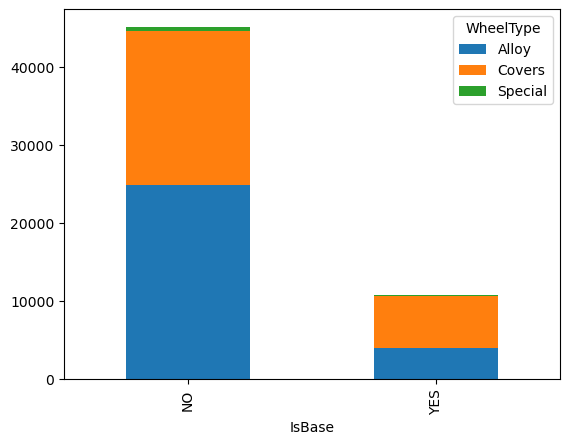

In [16]:
pclass_xt = pd.crosstab(df['IsBase'], df['WheelType'])
pclass_xt.plot(kind='bar', stacked=True)

I replace all the missing values of WheelType with the mode of the group related to base trim or not: if the vehicle is not base then alloy is the mode

In [17]:
df['WheelType'] = df.groupby(['IsBase']).WheelType.apply(lambda x: x.fillna(x.mode()[0]))
df['WheelType'].isnull().sum()

0

I don't do anything with wheelTypeID because in my opinion that attribute should be blended, it's so redundant with wheelType

In [18]:
df.drop('WheelTypeID', axis=1,inplace=True)

As far as nationality is concerned, we realize that the missing values are all from American brands. So TopThreeAmericanName will be OTHER anyway, and nationality will be american

In [19]:
df[df['Nationality'].isnull()][['TopThreeAmericanName', 'Transmission', 'Model', 'Make', 'Nationality']]

TopThreeAmericanName Transmission           Model   Make Nationality
15769                  NaN         AUTO     SIERRA 1500    GMC         NaN
18532                  NaN         AUTO    NITRO 4WD V6  DODGE         NaN
20016                  NaN         AUTO  PATRIOT 2WD 4C   JEEP         NaN
35157                  NaN         AUTO  PATRIOT 2WD 4C   JEEP         NaN

In [20]:
df['TopThreeAmericanName'].fillna('OTHER', inplace=True)
df['TopThreeAmericanName'].isnull().sum()

0

In [21]:
df['Nationality'].fillna('OTHER', inplace=True)
df['Nationality'].isnull().sum()

0

Now let's check the transmission's missing values, and we notice that the distribution is much closer to the automatic gearbox than the manual one, so we use the mode. Furthermore, looking at the missing values, we notice that they are all American cars.

In [22]:
df[df['Transmission'].isnull()][['TopThreeAmericanName', 'Transmission', 'Model', 'Make']]

TopThreeAmericanName Transmission                 Model       Make
23019                   GM          NaN    IMPALA 3.4L V6 SFI  CHEVROLET
28280                 FORD          NaN  FREESTAR FWD V6 3.9L       FORD
28961                   GM          NaN   GRAND AM V6 3.4L V6    PONTIAC
33225                 FORD          NaN  MOUNTAINEER 2WD V8 4    MERCURY
35224             CHRYSLER          NaN  STRATUS V6 2.7L V6 M      DODGE
40504                 FORD          NaN   MONTEGO 3.0L V6 EFI    MERCURY
48641             CHRYSLER          NaN  STRATUS V6 2.7L V6 M      DODGE
50661                   GM          NaN  S10 PICKUP 2WD 4C 2.  CHEVROLET

<AxesSubplot:ylabel='Transmission'>

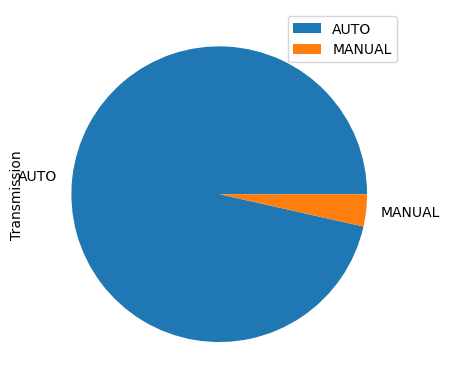

In [23]:
df['Transmission'].value_counts().plot.pie(legend=True)

In [24]:
df['Transmission'].fillna(df['Transmission'].mode()[0], inplace=True)
df['Transmission'].isnull().sum()

0

As far as color is concerned, we tried to group on significant attributes (make, size, year), but in any case the fashion was always SILVER.

<AxesSubplot:xlabel='Make'>

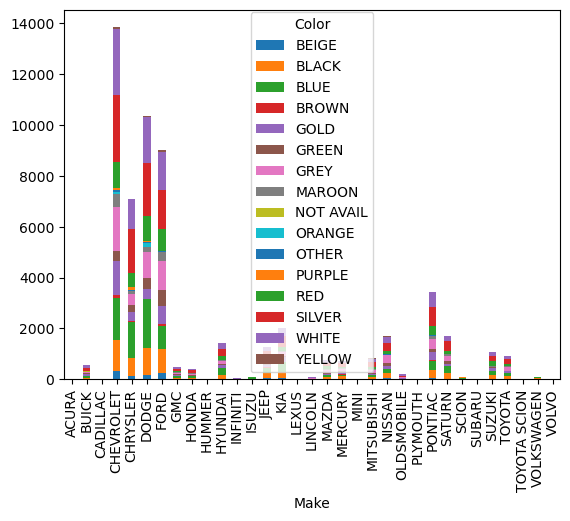

In [25]:
pclass_xt = pd.crosstab(df['Make'], df['Color'])
pclass_xt.plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='VehYear'>

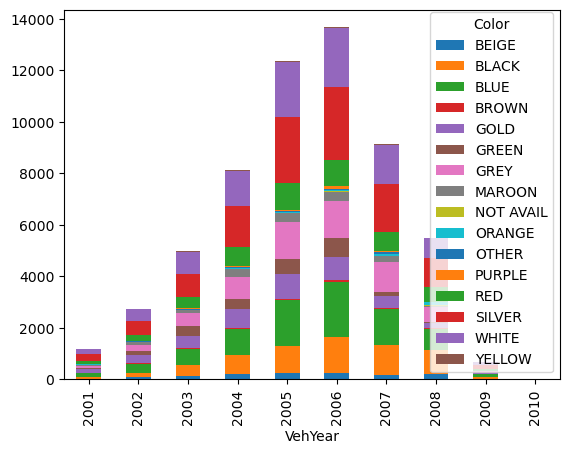

In [26]:
pclass_xt = pd.crosstab(df['VehYear'], df['Color'])
pclass_xt.plot(kind='bar', stacked=True)

In [27]:
df[df['Color'].isnull()][['TopThreeAmericanName', 'Transmission', 'Model', 'Make', 'Color']]

Empty DataFrame
Columns: [TopThreeAmericanName, Transmission, Model, Make, Color]
Index: []

In [28]:
df['Color'].fillna(df['Color'].mode()[0], inplace=True) #Impute missing values with mode of colour
df['Color'].isnull().sum()

0

Now size, we've noticed that different brands have different distributions, so let's group on make and get fashion

<AxesSubplot:xlabel='Make'>

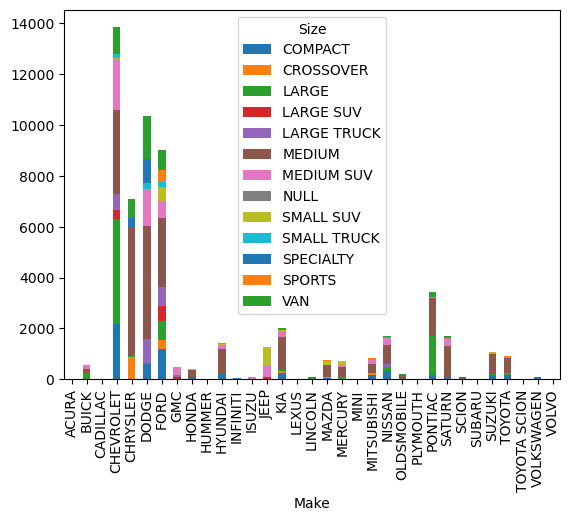

In [29]:
pclass_xt = pd.crosstab(df['Make'], df['Size'])
pclass_xt.plot(kind='bar', stacked=True)

In [30]:
df[df['Size'].isnull()][['TopThreeAmericanName', 'Transmission', 'Model', 'Make', 'Color']]

Empty DataFrame
Columns: [TopThreeAmericanName, Transmission, Model, Make, Color]
Index: []

In [31]:
df['Size'] = df.groupby(['Make']).Size.apply(lambda x: x.fillna(x.mode()[0]))
df['Size'].isnull().sum()

0

In [32]:
df[df['SubModel'].isnull()][['TopThreeAmericanName', 'Nationality', 'Model', 'Make', 'SubModel']]

Empty DataFrame
Columns: [TopThreeAmericanName, Nationality, Model, Make, SubModel]
Index: []

In [33]:
df['SubModel'] = df.groupby([df['Make'], df['Model']]).Size.apply(lambda x: x.fillna(x.mode()[0]))
df['SubModel'].isnull().sum()

0

In [34]:
sum_ = df.isnull().sum()
sum_[sum_ != 0]

Trim    1911
AAAP      13
AACP      13
ARAP      13
ARCP      13
CAAP      13
CACP      13
CRAP      13
CRCP      13
dtype: int64

In [35]:
# create a boolean mask that checks for missing values, except in the 'Trim' column
mask = df.drop('Trim', axis=1).isnull().any(axis=1)

# use the boolean mask to index the DataFrame and display the rows with missing values
result = df.loc[mask]
print(result)

       RefId  IsBadBuy   PurchDate  Auction  VehYear  VehicleAge      Make  \
1303   36536         0  10/14/2009  MANHEIM     2007           2      JEEP   
2260   26795         0   5/11/2010  MANHEIM     2004           6    NISSAN   
9869     737         0   9/15/2010    ADESA     2007           3     DODGE   
9960    7391         0  11/12/2009  MANHEIM     2004           5    NISSAN   
13686   6557         0    6/1/2010  MANHEIM     2004           6    NISSAN   
35487  52093         0   7/21/2010  MANHEIM     2004           6    NISSAN   
38625  68576         0   8/19/2010    ADESA     2007           3     DODGE   
41460  11824         0  11/23/2010  MANHEIM     2004           6    NISSAN   
44247  13262         0  12/13/2010  MANHEIM     2007           3     DODGE   
45677  64962         0    7/7/2009  MANHEIM     2003           6      FORD   
53298  30299         0   7/14/2010  MANHEIM     2008           2  CHRYSLER   
54838  36408         0    9/9/2009  MANHEIM     2003           6

In [36]:
# We notice that a set of 13 rows have all the price columns missing. Hence, we delete those rows
df.dropna(subset=df.columns.difference(['Trim']), inplace=True)
# Replace missing values in 'Trim' column with the most frequent value
df['Trim'].fillna(df['Trim'].mode()[0], inplace=True)
sum_ = df.isnull().sum()
sum_[sum_ != 0]

Series([], dtype: int64)

Perfect, at this point no missing value is left. We just need to enter the variable(s) to add for the averages, remove the useless ones

## Handling  Outliers

In [37]:
len(df[df['VehBCost'] <= 0]) # number of items where cost <= 0

0

In [38]:
len([(y, a) for y, a in zip(df['VehYear'], df['VehicleAge']) if a+y < 2009 or a+y > 2010]) # the years are all correct

0

In [39]:
len(df[df['VehOdo'] <= 0]) # number of items where the odometer is <= 0

0

In [40]:
len(df[df['WarrantyCost'] <= 0])
# number of items where warranty cost is <= 0

0

Now we verify that in any case, the purchase of a clean vehicle (above average condition) costs more than the average one (and in fact it always comes out perfect in any case

In [41]:
len([(x,y) for x,y in zip(df['AAAP'], df['AACP']) if x>y])


0

In [42]:
len([(x,y) for x,y in zip(df['ARAP'], df['ARCP']) if x>y])


0

In [43]:
len([(x,y) for x,y in zip(df['CAAP'], df['CACP']) if x>y])


0

In [44]:
len([(x,y) for x,y in zip(df['CRAP'], df['CRCP']) if x>y])


0

In [45]:
cols_to_drop = ['RefId', 'VehYear', 'IsBadBuy', 'BYRNO', 'VNZIP1', 'IsOnlineSale']
numeric_df = df.drop(columns=cols_to_drop).select_dtypes(include=np.number)
corr = numeric_df.corr()
corr

VehicleAge    VehOdo      AAAP      AACP      ARAP      ARCP  \
VehicleAge      1.000000  0.318792 -0.567106 -0.519897 -0.462299 -0.427526   
VehOdo          0.318792  1.000000 -0.018381  0.023717  0.029107  0.061407   
AAAP           -0.567106 -0.018381  1.000000  0.990218  0.910185  0.909832   
AACP           -0.519897  0.023717  0.990218  1.000000  0.902339  0.917934   
ARAP           -0.462299  0.029107  0.910185  0.902339  1.000000  0.990085   
ARCP           -0.427526  0.061407  0.909832  0.917934  0.990085  1.000000   
CAAP           -0.577315 -0.031646  0.937711  0.923314  0.851539  0.846458   
CACP           -0.533625  0.009738  0.932062  0.931812  0.849035  0.855196   
CRAP           -0.504961  0.012614  0.871222  0.860176  0.913097  0.903036   
CRCP           -0.469937  0.045298  0.870248  0.870637  0.905820  0.906593   
VehBCost       -0.312051 -0.064516  0.789354  0.781123  0.745718  0.744622   
WarrantyCost    0.258071  0.411276 -0.049682 -0.019607 -0.053507 -0.026708   

                  CAAP      CACP      CRAP      CRCP  VehBCost  WarrantyCost  
VehicleAge   -0.577315 -0.533625 -0.504961 -0.469937 -0.312051      0.258071  
VehOdo       -0.031646  0.009738  0.012614  0.045298 -0.064516      0.411276  
AAAP          0.937711  0.932062  0.871222  0.870248  0.789354     -0.049682  
AACP          0.923314  0.931812  0.860176  0.870637  0.781123     -0.019607  
ARAP          0.851539  0.849035  0.913097  0.905820  0.745718     -0.053507  
ARCP          0.846458  0.855196  0.903036  0.906593  0.744622     -0.026708  
CAAP          1.000000  0.990186  0.914976  0.911966  0.778548     -0.057364  
CACP          0.990186  1.000000  0.908573  0.921497  0.774857     -0.028459  
CRAP          0.914976  0.908573  1.000000  0.989685  0.756956     -0.059167  
CRCP          0.911966  0.921497  0.989685  1.000000  0.756563     -0.032946  
VehBCost      0.778548  0.774857  0.756956  0.756563  1.000000     -0.034007  
WarrantyCost -0.057364 -0.028459 -0.059167 -0.032946 -0.034007      1.000000

Removed date of purchase, auction, make, model, trim, sub-model, color, drivetrain, wheel type ID, nationality, size, top three US names, VNST.

Warranty Cost and vehicle: car with many km -> insurance costs a lot -> (perhaps) prob. bad buy?
There is a good correlation with all price-related attributes. Maybe we should spend some time later trying to get some sensible variable out of these values

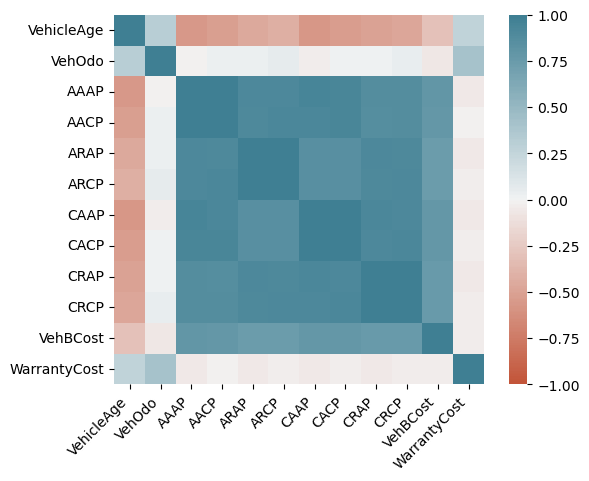

In [46]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

It can already be seen that the "VehicleAge" column is inversely correlated (about -0.5) with the price.
This makes a lot of sense as cars lose value over the years.

### Number of auctions by state

In [47]:
tmp = dict(df.groupby(['VNST']).size())
tmp

{'AL': 548,
 'AR': 56,
 'AZ': 4964,
 'CA': 5673,
 'CO': 4051,
 'FL': 8316,
 'GA': 1964,
 'IA': 398,
 'ID': 162,
 'IL': 376,
 'IN': 384,
 'KY': 183,
 'LA': 277,
 'MA': 11,
 'MD': 930,
 'MI': 12,
 'MN': 51,
 'MO': 591,
 'MS': 408,
 'NC': 5610,
 'NE': 23,
 'NH': 80,
 'NJ': 261,
 'NM': 202,
 'NV': 443,
 'NY': 4,
 'OH': 622,
 'OK': 2898,
 'OR': 160,
 'PA': 673,
 'SC': 3394,
 'TN': 1415,
 'TX': 10874,
 'UT': 699,
 'VA': 1326,
 'WA': 112,
 'WV': 222}

In [48]:
# Visualisation Number of auctions by state

fig = go.Figure(data= go.Choropleth(
    locations=list(tmp.keys()),
    z = list(tmp.values()),
    locationmode='USA-states',
    colorscale='YlGnBu'
    ))
fig.update_layout(
geo_scope='usa')

fig.show()

In [49]:
#VehicleCost vs WarrantyCost by Make
import random

x = df[['Make', 'WarrantyCost']].groupby('Make').mean()
x = [item for sublist in x.values.tolist() for item in sublist]

y = df[['Make', 'VehBCost']].groupby('Make').mean()
y = [item for sublist in y.values.tolist() for item in sublist]

z = list(dict(df.groupby(['Make']).size()).values())
z = [float(i)/100 for i in z]
names = list(dict(df.groupby(['Make']).size()).keys())

# Create figure
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers+text',
    text=names,
    textposition="middle center",
    marker=dict(
        size=z,
        color=[random.randint(0, 2000) for i in range(len(z))],
        colorscale="Rainbow"
    )
))

fig.update_layout(
    title="Warranty Cost vs Vehicle Cost",
    xaxis=dict(
        title="VehBCost",
        type='log'
    ),

    yaxis=dict(
        title="WarrantyCost",
    )
)
fig.show()

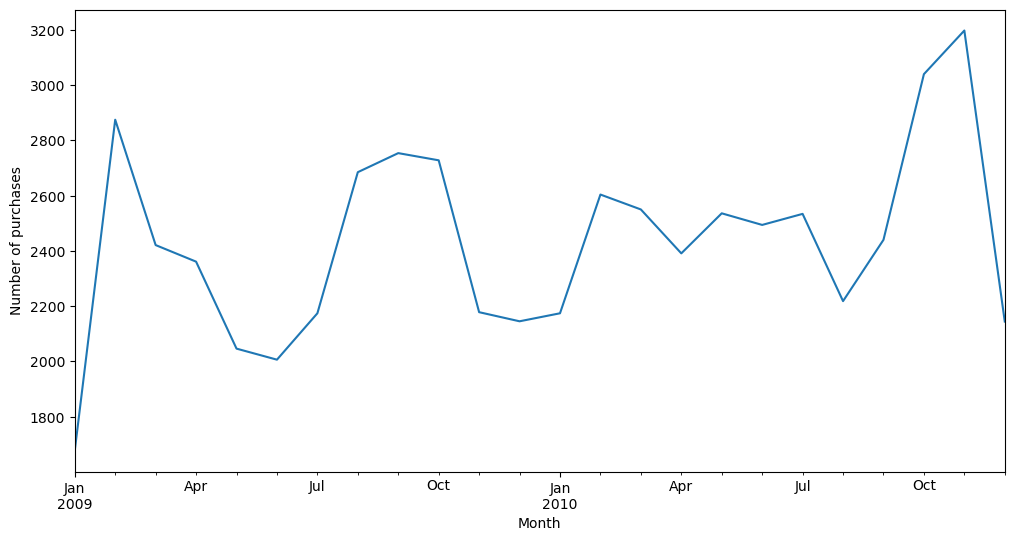

In [50]:
# convert the 'PurchDate' column to a datetime type
df['PurchDate'] = pd.to_datetime(df['PurchDate'])

# group the purchases by month and count the number of purchases in each month
ts = df.resample('M', on='PurchDate').size()

# plot the time series
fig, ax = plt.subplots(figsize=(12, 6))
ts.plot(ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Number of purchases')
plt.show()


Text(0.5, 1.0, 'VehBCost')

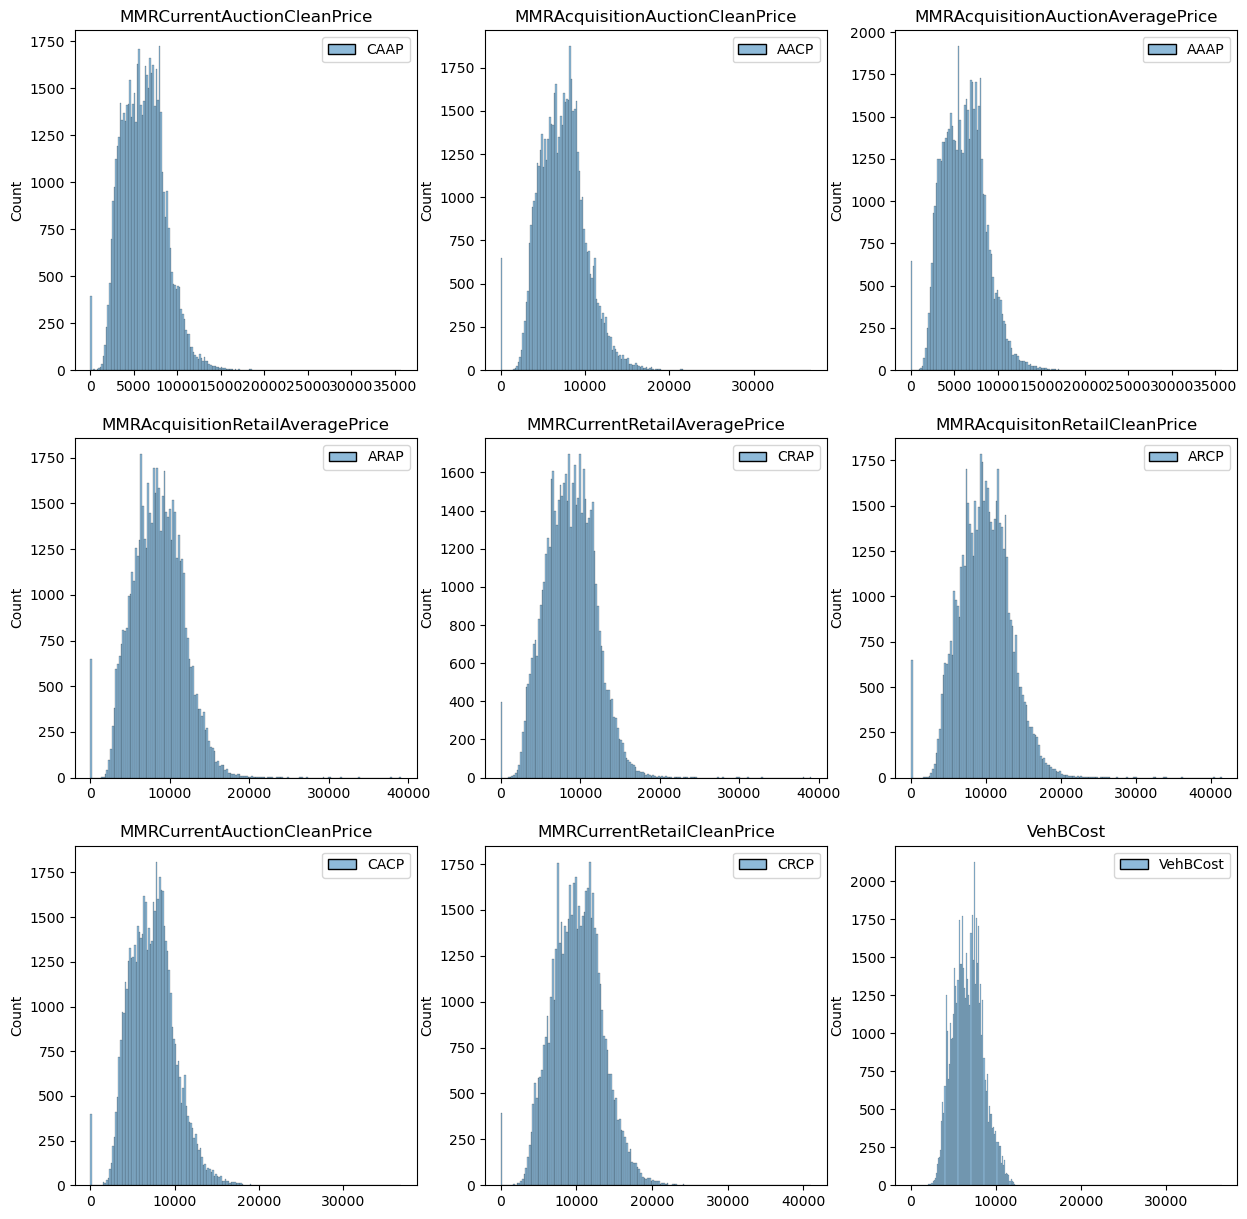

In [51]:
fig = plt.figure(figsize=(15, 15)) 
fig_dims = (3, 3)

plt.subplot2grid(fig_dims, (0, 0))
x = df[["CAAP"]].dropna()
sns.histplot(x);
plt.title('MMRCurrentAuctionCleanPrice')

plt.subplot2grid(fig_dims, (0, 1))
x = df[["AACP"]].dropna()
sns.histplot(x);
plt.title('MMRAcquisitionAuctionCleanPrice')

plt.subplot2grid(fig_dims, (0, 2))
x = df[["AAAP"]].dropna()
sns.histplot(x);
plt.title('MMRAcquisitionAuctionAveragePrice')


plt.subplot2grid(fig_dims, (1, 0))
x = df[["ARAP"]].dropna()
sns.histplot(x);
plt.title('MMRAcquisitionRetailAveragePrice')

plt.subplot2grid(fig_dims, (1, 1))
x = df[["CRAP"]].dropna()
sns.histplot(x);
plt.title('MMRCurrentRetailAveragePrice')

plt.subplot2grid(fig_dims, (1, 2))
x = df[["ARCP"]].dropna()
sns.histplot(x);
plt.title('MMRAcquisitonRetailCleanPrice')

plt.subplot2grid(fig_dims, (2, 0))
x = df[["CACP"]].dropna()
sns.histplot(x);
plt.title('MMRCurrentAuctionCleanPrice')

plt.subplot2grid(fig_dims, (2, 1))
x = df[["CRCP"]].dropna()
sns.histplot(x);
plt.title('MMRCurrentRetailCleanPrice')

plt.subplot2grid(fig_dims, (2, 2))
x = df[["VehBCost"]].dropna()
sns.histplot(x);
plt.title('VehBCost')

The code then uses the Counter function from the collections module to count the number of occurrences of each item in mostFreq and menoFreq, and stores the counts in the threeColors and other variables, respectively.

Finally, the code creates a pie chart using the matplotlib library. The chart displays the frequency of the three most common colors ("SILVER", "WHITE", and "BLUE") and the frequency of all other colors combined. The size and color of the wedges in the pie chart are determined by the frequency of the colors.

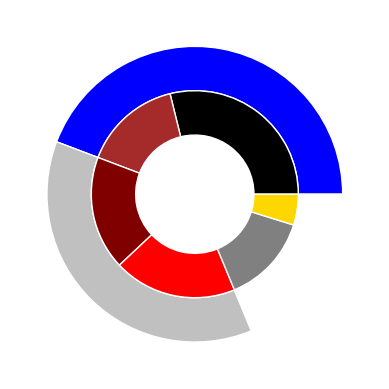

In [52]:
mostFreq = []
menoFreq = []
for i in df['Color']:
    if i == "SILVER" or i == "WHITE" or i == "BLUE":
        mostFreq.append(i)
    elif i != "OTHER" and i != "NOT AVAIL":
        menoFreq.append(i)
        
threeColors = Counter(mostFreq)
other = Counter(menoFreq)



fig, ax = plt.subplots()
size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

outer_colors = threeColors
inner_colors = other

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal")
plt.show()

plotting kernel density estimates (KDEs) for multiple columns ('CAAP', 'AACP', 'AAAP', 'ARAP', 'CRAP', 'ARCP', 'CACP', and 'CRCP') of a Pandas DataFrame using matplotlib's pyplot library.

The first line sets the x-axis limits of the plot to be from -2500 to 20200.

<AxesSubplot:ylabel='Density'>

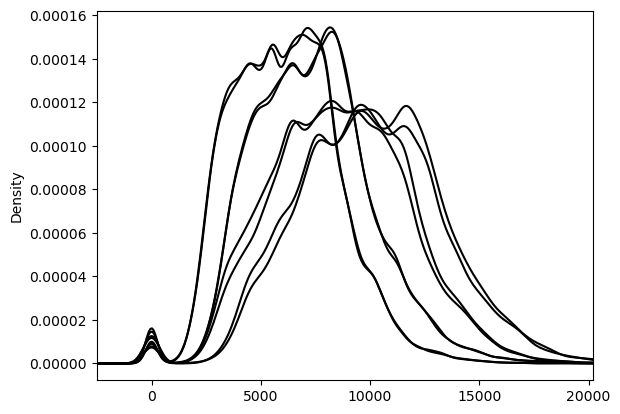

In [53]:
x = plt.xlim((-2500, 20200))
df["CAAP"].plot.kde(x = 'x', color = 'black') 
df['AACP'].plot.kde(x = 'x', color = 'black')
df['AAAP'].plot.kde(x = 'x', color = 'black')
df['ARAP'].plot.kde(x = 'x', color = 'black')
df['CRAP'].plot.kde(x = 'x', color = 'black')
df['ARCP'].plot.kde(x = 'x', color = 'black')
df['CACP'].plot.kde(x = 'x', color = 'black')
df['CRCP'].plot.kde(x = 'x', color = 'black')

In [54]:
pclass_xt = pd.crosstab(df['Transmission'], df['WheelType'])
pclass_xt

WheelType     Alloy  Covers  Special
Transmission                        
AUTO          29860   25926      539
MANUAL          944    1054       50

<AxesSubplot:xlabel='Transmission'>

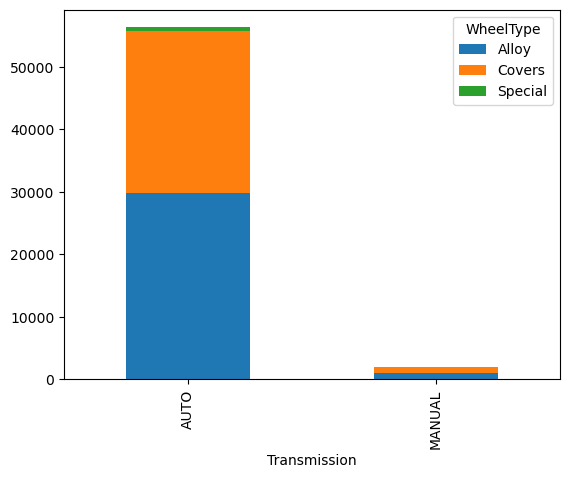

In [55]:
pclass_xt.plot(kind='bar', stacked=True)

<AxesSubplot:>

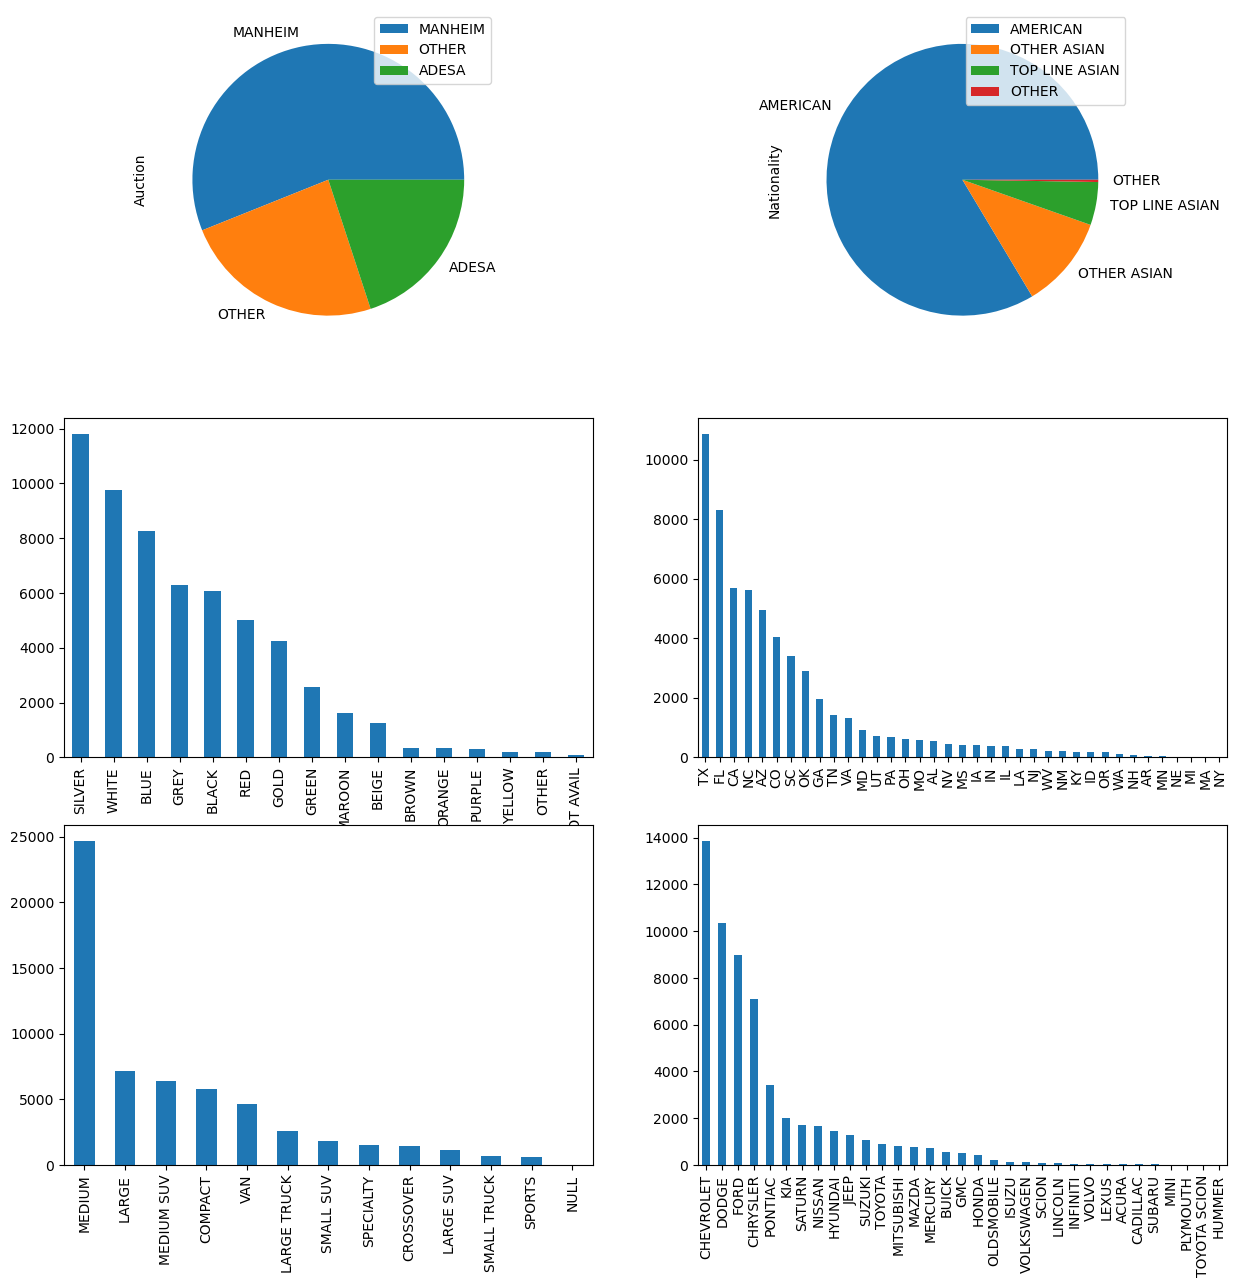

In [56]:
fig = plt.figure(figsize=(15, 15)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (0, 0))
df['Auction'].value_counts().plot.pie(legend=True)

plt.subplot2grid(fig_dims, (0, 1))
df['Nationality'].value_counts().plot.pie(legend=True)

plt.subplot2grid(fig_dims, (1, 0))
df['Color'].value_counts().plot(kind='bar')

plt.subplot2grid(fig_dims, (1, 1))
df['VNST'].value_counts().plot(kind='bar')

plt.subplot2grid(fig_dims, (2, 0))
df['Size'].value_counts().plot(kind='bar')

plt.subplot2grid(fig_dims, (2, 1))
df['Make'].value_counts().plot(kind='bar')

the code uses the pandas crosstab function to create a contingency table or frequency table of counts for the two variables. The resulting object 'pclass_xt' is a Pandas DataFrame containing the counts of 'IsBadBuy' for each value of 'WheelTypeIDDelete'.

Now I have to do the same thing for the other current values

Here in my opinion it is nice to point out that in general bad buys are found in 2 areas

On practically new machines (low odometer and low warranty cost)

On used and risky cars (high guarantee, odometer around 40000-80000

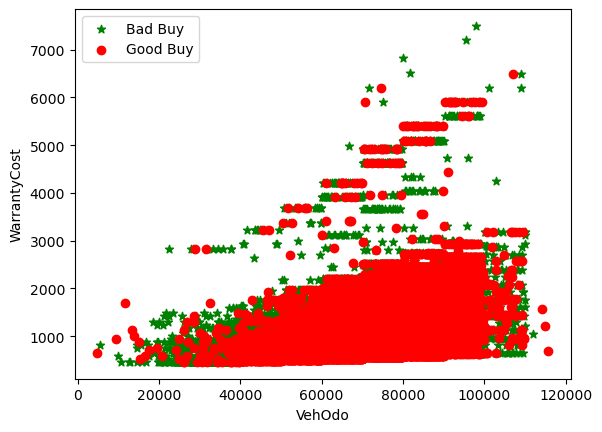

In [57]:
plt.scatter(df[df['IsBadBuy'] == 0]['VehOdo'], 
            df[df['IsBadBuy'] == 0]['WarrantyCost'], color='g', marker='*', label='Bad Buy')
plt.scatter(df[df['IsBadBuy'] == 1]['VehOdo'], 
            df[df['IsBadBuy'] == 1]['WarrantyCost'], color='r',label='Good Buy')
plt.xlabel('VehOdo')
plt.ylabel('WarrantyCost')
plt.legend()
plt.show()

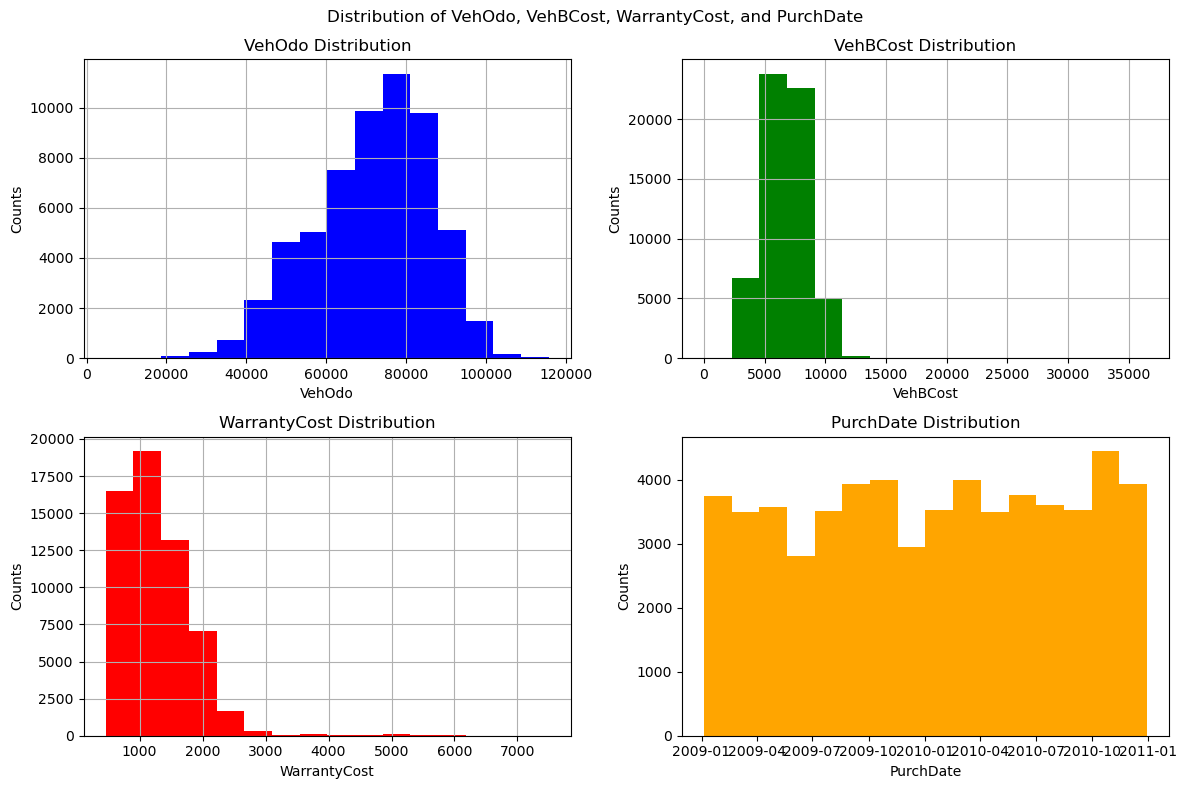

In [58]:
# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot histograms for VehOdo, VehBCost, WarrantyCost, and PurchDate
df['VehOdo'].hist(bins=16, ax=axs[0, 0], color='blue')
df['VehBCost'].hist(bins=16, ax=axs[0, 1], color='green')
df['WarrantyCost'].hist(bins=16, ax=axs[1, 0], color='red')
a = pd.Series(df['PurchDate'])
axs[1, 1].hist(a, bins=16, color='orange')

# Add titles and labels for each subplot
axs[0, 0].set_title('VehOdo Distribution')
axs[0, 0].set_xlabel('VehOdo')
axs[0, 0].set_ylabel('Counts')
axs[0, 1].set_title('VehBCost Distribution')
axs[0, 1].set_xlabel('VehBCost')
axs[0, 1].set_ylabel('Counts')
axs[1, 0].set_title('WarrantyCost Distribution')
axs[1, 0].set_xlabel('WarrantyCost')
axs[1, 0].set_ylabel('Counts')
axs[1, 1].set_title('PurchDate Distribution')
axs[1, 1].set_xlabel('PurchDate')
axs[1, 1].set_ylabel('Counts')

# Add a common title for the entire figure
fig.suptitle('Distribution of VehOdo, VehBCost, WarrantyCost, and PurchDate')

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


# Variable Substitution & Redundancy Elimination

In [59]:
PAC = ['WA' ,'OR','AK','HI','CA']
MNT = ['MT' ,'WY','ID','NV','UT','CO','AZ','NM']
WNC = ['ND' ,'MN','SD','IA','NE','KS','MO']
WSC = ['OK' ,'AR','TX','LA']
ENC = ['WI' ,'MI','OH','IN','IL']
ESC = ['KY' ,'TN','MS','AL']
MAT = ['NY' ,'PA','NJ']
SAT = ['WV' ,'MD','DE','DC','VA','NC','SC','GA','FL']
NEN = ['ME' ,'NH','VT','MA','CT','RI']

In [60]:
list2 = []
for i in df['VNST']:
    if i in PAC:
        list2.append('PAC')
    elif i in MNT:
        list2.append('MNT')
    elif i in WNC:
        list2.append('WNC')
    elif i in WSC:
        list2.append('WSC')
    elif i in ENC:
        list2.append('ENC')
    elif i in ESC:
        list2.append('ESC')
    elif i in MAT:
        list2.append('MAT')
    elif i in SAT:
        list2.append('SAT')
    elif i in NEN:
        list2.append('NEN')
    else:
        list2.append('XXX')

df['Region'] = list2

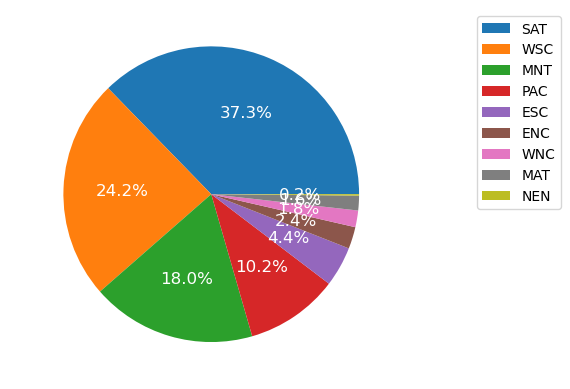

In [61]:
plot = df['Region'].value_counts().plot.pie(legend=True,autopct='%1.1f%%',textprops=dict(color="w",size="12"))
plot.legend(bbox_to_anchor=(1.2,1), loc="upper left")
plot.axes.get_yaxis().set_visible(False)

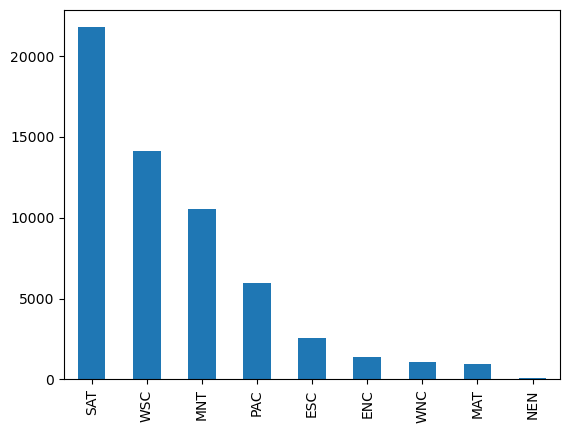

In [62]:
plot = df['Region'].value_counts().plot(kind='bar')

In [63]:
df.isnull().sum()

RefId                   0
IsBadBuy                0
PurchDate               0
Auction                 0
VehYear                 0
VehicleAge              0
Make                    0
Model                   0
Trim                    0
SubModel                0
Color                   0
Transmission            0
WheelType               0
VehOdo                  0
Nationality             0
Size                    0
TopThreeAmericanName    0
AAAP                    0
AACP                    0
ARAP                    0
ARCP                    0
CAAP                    0
CACP                    0
CRAP                    0
CRCP                    0
BYRNO                   0
VNZIP1                  0
VNST                    0
VehBCost                0
IsOnlineSale            0
WarrantyCost            0
IsBase                  0
Region                  0
dtype: int64

In [64]:
df.sort_values(['VehBCost'])['VehBCost'].head()

40998       1.0
53937     225.0
26371    1400.0
31167    1620.0
26693    1720.0
Name: VehBCost, dtype: float64

In [65]:
sum_ = df.isnull().sum()
sum_[sum_ == 0]

RefId                   0
IsBadBuy                0
PurchDate               0
Auction                 0
VehYear                 0
VehicleAge              0
Make                    0
Model                   0
Trim                    0
SubModel                0
Color                   0
Transmission            0
WheelType               0
VehOdo                  0
Nationality             0
Size                    0
TopThreeAmericanName    0
AAAP                    0
AACP                    0
ARAP                    0
ARCP                    0
CAAP                    0
CACP                    0
CRAP                    0
CRCP                    0
BYRNO                   0
VNZIP1                  0
VNST                    0
VehBCost                0
IsOnlineSale            0
WarrantyCost            0
IsBase                  0
Region                  0
dtype: int64

In [66]:
df.drop(columns=['Trim', 'VehYear', 'VNZIP1', 'VNST'], inplace=True)

df.isnull().sum()

RefId                   0
IsBadBuy                0
PurchDate               0
Auction                 0
VehicleAge              0
Make                    0
Model                   0
SubModel                0
Color                   0
Transmission            0
WheelType               0
VehOdo                  0
Nationality             0
Size                    0
TopThreeAmericanName    0
AAAP                    0
AACP                    0
ARAP                    0
ARCP                    0
CAAP                    0
CACP                    0
CRAP                    0
CRCP                    0
BYRNO                   0
VehBCost                0
IsOnlineSale            0
WarrantyCost            0
IsBase                  0
Region                  0
dtype: int64

Three new variables are inserted below:

AuctionAVG: This is an average of all available values with Auction in the name (XAXX). 

RetailAVG: It is an average of all available values with Retail in the name (XRXX). 

Trend: It is a number that increases in module the higher the difference between average and current.

If current > average then trend is positive, otherwise negative. If I have no current or average available, the trend is 0
At the end I print 4 values in 5 lines. 

The i-th line reads as:

"number of XAXX (average) of which I found only filled lines, same thing as XCXX, same thing as AXXX, same thing

Removing outliers

In [67]:
thresh = 1000

# Find rows to delete
to_delete = df[(df['AAAP'] < thresh) &
   (df['AACP'] < thresh) &
   (df['ARAP'] < thresh) &
   (df['ARCP'] < thresh) &
   (df['CAAP'] < thresh) &
   (df['CACP'] < thresh) &
   (df['CRAP'] < thresh) &
   (df['CRCP'] < thresh)].index.tolist()

auction_delete = df[(df['AAAP'] < thresh) &
   (df['AACP'] < thresh) &
   (df['CAAP'] < thresh) &
   (df['CACP'] < thresh)].index.tolist()

retail_delete = df[(df['CRAP'] < thresh) &
   (df['CRCP'] < thresh) &
   (df['ARAP'] < thresh) &
   (df['ARCP'] < thresh)].index.tolist()

# Combine all rows to delete
to_delete += auction_delete + retail_delete
to_delete = list(dict.fromkeys(to_delete))

# Delete rows
df = df.drop(index=to_delete)

# Print number of rows remaining
print("Number of rows remaining:", len(df))

# Print some data to verify deletion
print(df['VehBCost'].sort_values().head())


Number of rows remaining: 58015
40998       1.0
53937     225.0
26371    1400.0
31167    1620.0
26693    1720.0
Name: VehBCost, dtype: float64


In [68]:
list_auct = []
list_ret = []
prova_auc = []
prova_ret = []
prova_acquis = []
prova_current = []
trend =  []

for i, row in df.iterrows():
    n_ret = 0
    n_auc = 0
    n_acquis = 0
    n_current = 0
    retail = 0
    current = 0
    acquis = 0
    auction = 0
    # auction
    if row['AAAP'] >= thresh:
        n_auc = n_auc + 1
        n_acquis = n_acquis + 1
        acquis = acquis + row['AAAP']
        auction = auction + row['AAAP']
    if row['AACP'] >= thresh:
        n_auc = n_auc + 1
        n_acquis = n_acquis + 1
        auction = auction + row['AACP']
        acquis = acquis + row['AACP']
    if row['CAAP'] >= thresh:
        n_auc = n_auc + 1
        n_current = n_current + 1
        current = current + row['CAAP']
        auction = auction + row['CAAP']
    if row['CACP'] >= thresh:
        n_auc = n_auc + 1
        n_current = n_current + 1
        current = current + row['CACP']
        auction = auction + row['CACP']
    #retail
    if row['ARAP'] >= thresh:
        n_ret = n_ret + 1
        n_acquis = n_acquis + 1
        acquis = acquis + row['ARAP']
        retail = retail + row['ARAP']
    if row['ARCP'] >= thresh:
        n_ret = n_ret + 1
        n_acquis = n_acquis + 1
        acquis = acquis + row['ARCP']
        retail = retail + row['ARCP']
    if row['CRAP'] >= thresh:
        n_ret = n_ret + 1
        n_current = n_current + 1
        current = current + row['CRAP']
        retail = retail + row['CRAP']
    if row['CRCP'] >= thresh:
        n_ret = n_ret + 1
        n_current = n_current + 1
        current = current + row['CRCP']
        retail = retail + row['CRCP']
        
    list_auct.append((auction / n_auc))
    list_ret.append((retail / n_ret))
    
    if n_acquis == 0 or n_current == 0:
        trend.append(0)
    else:
        a = (current - acquis) / (current + acquis)
        trend.append(a)
    
    prova_auc.append(n_auc)
    prova_ret.append(n_ret)
    prova_acquis.append(n_acquis)
    prova_current.append(n_current)
        
df['AuctionAVG'] = list_auct
df['RetailAVG'] = list_ret
df['Trend'] = trend

for i in range (0,5):
    print(prova_auc.count(i), " " , prova_ret.count(i), " ", prova_acquis.count(i), " " , prova_current.count(i))


0   0   290   38
0   0   0   3
332   328   0   0
12   3   2   12
57671   57684   57723   57962


In [69]:
a = df[df['IsBadBuy']== 0]['RefId'].count()
b = df[df['IsBadBuy']== 1]['RefId'].count() 
(a*100)/(a+b)
# distribution of goodBuy vs badBuy

87.65319313970525

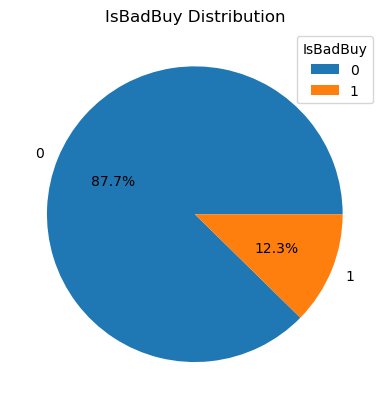

In [70]:
#visualising variabile "IsBadBuy"
fig, ax = plt.subplots()
ax.pie(df['IsBadBuy'].value_counts(), labels=df['IsBadBuy'].value_counts().index, autopct='%1.1f%%')

# Add title and legend
ax.set_title('IsBadBuy Distribution')
ax.legend(title='IsBadBuy')

# Show the plot
plt.show()

In [71]:
df.head()

RefId  IsBadBuy  PurchDate  Auction  VehicleAge      Make  \
0    326         1 2010-10-25    ADESA           2       KIA   
1  42991         0 2009-05-27  MANHEIM           3     DODGE   
2  55273         0 2010-03-18    OTHER           2     DODGE   
3  29058         0 2009-06-08    OTHER           4      FORD   
4  34991         0 2009-03-04  MANHEIM           4  CHRYSLER   

                  Model SubModel   Color Transmission WheelType  VehOdo  \
0               SPECTRA   MEDIUM    BLUE         AUTO    Covers   61184   
1  STRATUS V6 2.7L V6 M   MEDIUM  SILVER         AUTO    Covers   92383   
2               CALIBER   MEDIUM   BLACK         AUTO    Covers   45965   
3  FREESTAR FWD V6 3.9L      VAN   BROWN         AUTO    Covers   80169   
4  TOWN & COUNTRY FWD V      VAN    BLUE         AUTO     Alloy   77372   

   Nationality    Size TopThreeAmericanName    AAAP    AACP     ARAP     ARCP  \
0  OTHER ASIAN  MEDIUM                OTHER  6796.0  7555.0  10140.0  10805.0   
1     AMERICAN  MEDIUM             CHRYSLER  5480.0  6461.0   6418.0   7478.0   
2     AMERICAN  MEDIUM             CHRYSLER  8067.0  8580.0  11073.0  11652.0   
3     AMERICAN     VAN                 FORD  4817.0  6658.0   5702.0   7691.0   
4     AMERICAN     VAN             CHRYSLER  5430.0  6633.0   6364.0   7664.0   

     CAAP    CACP     CRAP     CRCP  BYRNO  VehBCost  IsOnlineSale  \
0  6628.0  7535.0   9605.0  10650.0   5546    6100.0             0   
1  5480.0  6461.0   6418.0   7478.0  99750    4000.0             0   
2  7497.0  8102.0  10721.0  11350.0  99761    7500.0             0   
3  4817.0  6658.0   5702.0   7691.0  99761    4725.0             0   
4  5370.0  6811.0   6300.0   7856.0  20833    5670.0             0   

   WarrantyCost IsBase Region  AuctionAVG  RetailAVG     Trend  
0           533     NO    SAT      7128.5    10300.0 -0.012594  
1          1630     NO    SAT      5970.5     6948.0  0.000000  
2           693     NO    WSC      8061.5    11199.0 -0.022092  
3          1633     NO    MNT      5737.5     6696.5  0.000000  
4          1623    YES    WSC      6061.0     7046.0  0.004692

In [72]:
for col in df.columns:
    print(col)

RefId
IsBadBuy
PurchDate
Auction
VehicleAge
Make
Model
SubModel
Color
Transmission
WheelType
VehOdo
Nationality
Size
TopThreeAmericanName
AAAP
AACP
ARAP
ARCP
CAAP
CACP
CRAP
CRCP
BYRNO
VehBCost
IsOnlineSale
WarrantyCost
IsBase
Region
AuctionAVG
RetailAVG
Trend


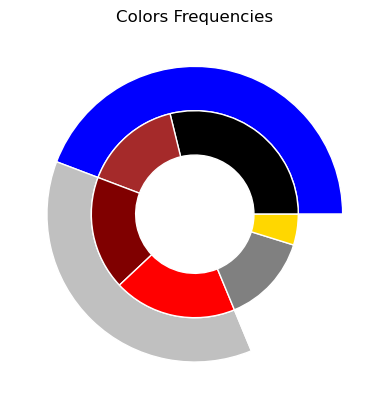

In [73]:
mostFreq = []
menoFreq = []
for i in df['Color']:
    if i == "SILVER" or i == "WHITE" or i == "BLUE":
        mostFreq.append(i)
    elif i != "OTHER" and i != "NOT AVAIL":
        menoFreq.append(i)
        
threeColors = Counter(mostFreq)
other = Counter(menoFreq)



fig, ax = plt.subplots()
size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

outer_colors = threeColors
inner_colors = other

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Colors Frequencies')
plt.show()

<AxesSubplot:ylabel='Density'>

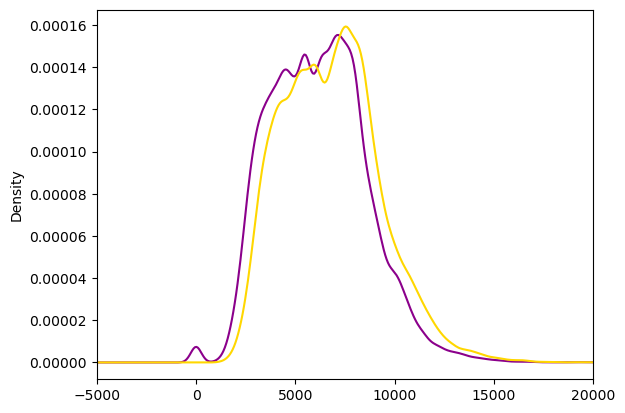

In [74]:
#Two variables compared:
#- AuctionAVG in new dataframe after modification
#- AAAP old Dataframe before modification

x = plt.xlim((-5000, 20000))
df["AAAP"].plot.kde(x = 'x', color = 'darkmagenta') 
df['AuctionAVG'].plot.kde (x = 'x', color = 'gold')

<AxesSubplot:ylabel='Density'>

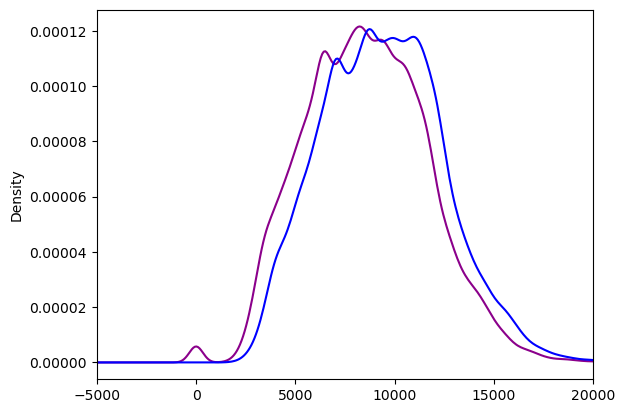

In [75]:
#Two variables compared:
#- RetailAVG in new dataframe after modification
#- ARAP old Dataframe before modification

x = plt.xlim((-5000, 20000))
df["ARAP"].plot.kde(x = 'x', color = 'darkmagenta') 
df['RetailAVG'].plot.kde(x = 'x', color = 'blue')

<AxesSubplot:ylabel='Density'>

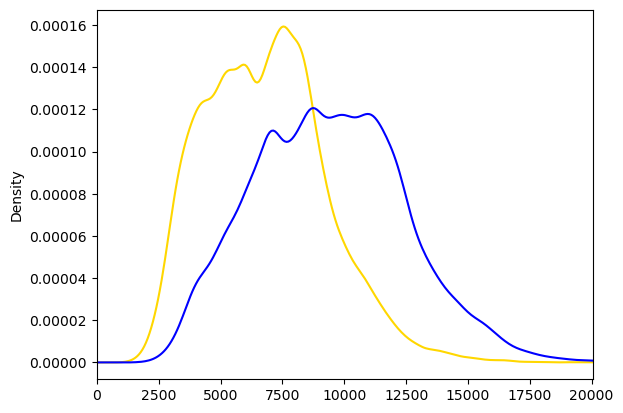

In [76]:
x = plt.xlim((0, 20050))
df["AuctionAVG"].plot.kde(x = 'x', color = 'gold') 
df['RetailAVG'].plot.kde(x = 'x', color = 'blue')

In [77]:
df.drop(columns=['AAAP', 'AACP', 'CAAP', 'CACP', 'ARAP', 'ARCP', 'CRAP', 'CRCP'], inplace=True)

In [78]:
df.to_csv('training_cleaned.csv', index=False)